# Getting Started: Loading, Processing, Visualizing, and Storing Data

This short notebook demostrates how `landlensdb` can be used to load, process, visualize, and store street-view data from local file directories and Mapillary servers.

## Pre-requisites

Before getting started, you will need to have [PostgreSQL](https://www.postgresql.org/download/) and [PostGIS](https://postgis.net/documentation/getting_started/) installed. 

### PostgreSQL and PostGIS
Once PostgreSQL and PostGIS are installed, or if they are already installed, then you will need to have a PostGIS enabled PostgreSQL database to work with. To create one, use:

```bash
createdb <database_name> && psql <database_name> -c "CREATE EXTENSION POSTGIS"
```

Be sure to replace `<database_name>` with the name you want to call your database. For example, it could be:

```bash
createdb landlens && psql landlens -c "CREATE EXTENSION POSTGIS"
```

### Mapillary Token
You will also need to have a Mapillary API token. This isnt necessary to use the library, but you will need it to follow the tutorial, which includes examples on connecting to Mapillary and downloading images.

### .env File
Finally, you will need to save this information into a `.env` file. To create a `.env` file, use:

```bash
touch .env
```

Then, paste the following:

```
MLY_TOKEN=<token>
LOCAL_IMAGES=<path_to_local_images>
DOWNLOAD_DIR=<path_to_download_images_do>
DATABASE_URL=<PostgreSQL_database_url>
DB_TABLE=<table_name>
```

Replace the text enclosed by angular brackets `<>` with the actual text. For example, your `MLY_TOKEN` would be the Mapillary token you can acquire from a Mapillary account. Usually, these start with `MLY|`. The path variables are absolute paths to where you want files to be read or written. The database URL, if the database was created using the earlier instructions, would look like: `postgresql://localhost:5432/landlens`, assuming PostgreSQL is being served on localhost with port 5432 (the default). The `DB_TABLE` will be the table name to use in this tutorial. It can be anything, for example: `mapillary_images`. 

Once this is done, you should be ready to proceed with the tutorial.

If you don't have `landlens_db` installed, you can do so with `pip install landlensdb`.

In [6]:
from landlensdb.handlers.cloud import Mapillary
from landlensdb.handlers.image import Local
from landlensdb.process.snap import create_bbox, get_osm_lines, snap_to_road_network
from landlensdb.handlers.db import Postgres
from landlensdb.geoclasses.geoimageframe import GeoImageFrame

ModuleNotFoundError: No module named 'landlensdb.handlers.image.Local'; 'landlensdb.handlers.image' is not a package

Before we get started, we will need to load our Mapillary API token and other environmental variables. For simplicity, we will use the `dotenv` library to please install this and create a .env file to follow this tutorial. You will also need to make sure that pandas and geopandas are installed in order to manipulate some of the data required for the tutorial.

In [4]:
import os
import geopandas as gpd
import glob
import pandas as pd

from dotenv import load_dotenv

load_dotenv()

MLY_TOKEN = os.environ.get("MLY_TOKEN")
DOWNLOAD_DIR = os.environ.get("DOWNLOAD_DIR")
DATABASE_URL = os.environ.get("DATABASE_URL")
DB_TABLE = os.environ.get("DB_TABLE")

# Loading Images

`landlensdb` provides two simple ways to load images for the first time which can then be processed and stored for further analysis.

## 1. Loading images from local directory

To load images from a local directory, simply call the `load_images` function while providing the source directory to read from. Currently, only `jpeg` images are supported and it is best to provide the full path to the images.

In [8]:
relative_path = "../example_data/360_images"
absolute_path = os.path.abspath(relative_path)

local_images = Local.load_images(absolute_path)
local_images

,name,altitude,camera_type,camera_parameters,captured_at,compass_angle,exif_orientation,image_url,thumb_url,geometry
0,R0012879.JPG,165.970001,360-degree,NaN,2023-03-08T12:27:53+03:00,NaN,1.0,/Users/iosefa/repos/landlensdb/docs/example_da...,/Users/iosefa/repos/landlensdb/docs/example_da...,POINT (46.80805 -16.31965)
1,R0012878.JPG,164.880005,360-degree,NaN,2023-03-08T12:27:42+03:00,NaN,1.0,/Users/iosefa/repos/landlensdb/docs/example_da...,/Users/iosefa/repos/landlensdb/docs/example_da...,POINT (46.80793 -16.31968)
2,R0012882.JPG,172.119995,360-degree,NaN,2023-03-08T12:28:26+03:00,NaN,1.0,/Users/iosefa/repos/landlensdb/docs/example_da...,/Users/iosefa/repos/landlensdb/docs/example_da...,POINT (46.80824 -16.31961)
3,R0012880.JPG,166.559998,360-degree,NaN,2023-03-08T12:28:04+03:00,NaN,1.0,/Users/iosefa/repos/landlensdb/docs/example_da...,/Users/iosefa/repos/landlensdb/docs/example_da...,POINT (46.80807 -16.31964)
4,R0012881.JPG,169.259995,360-degree,NaN,2023-03-08T12:28:15+03:00,NaN,1.0,/Users/iosefa/repos/landlensdb/docs/example_da...,/Users/iosefa/repos/landlensdb/docs/example_da...,POINT (46.80812 -16.31962)
5,R0012873.JPG,171.250000,360-degree,NaN,2023-03-08T12:26:45+03:00,NaN,1.0,/Users/iosefa/repos/landlensdb/docs/example_da...,/Users/iosefa/repos/landlensdb/docs/example_da...,POINT (46.80760 -16.31976)
6,R0012872.JPG,170.919998,360-degree,NaN,2023-03-08T12:26:34+03:00,NaN,1.0,/Users/iosefa/repos/landlensdb/docs/example_da...,/Users/iosefa/repos/landlensdb/docs/example_da...,POINT (46.80756 -16.31977)
7,R0012875.JPG,168.779999,360-degree,NaN,2023-03-08T12:27:08+03:00,NaN,1.0,/Users/iosefa/repos/landlensdb/docs/example_da...,/Users/iosefa/repos/landlensdb/docs/example_da...,POINT (46.80771 -16.31973)
8,R0012874.JPG,167.669998,360-degree,NaN,2023-03-08T12:26:56+03:00,NaN,1.0,/Users/iosefa/repos/landlensdb/docs/example_da...,/Users/iosefa/repos/landlensdb/docs/example_da...,POINT (46.80766 -16.31972)
9,R0012876.JPG,167.110001,360-degree,NaN,2023-03-08T12:27:19+03:00,NaN,1.0,/Users/iosefa/repos/landlensdb/docs/example_da...,/Users/iosefa/repos/landlensdb/docs/example_da...,POINT (46.80784 -16.31968)


The resulting image is a GeoImageFrame, which is a simple extension of a Pandas GeoDataFrame with a few required column definitions and additional methods for visualization and data verification.

## 2. Loading images from mapillary

`landlensdb` was made to work with Mapillary data and it includes helper functions to make calls to the Mapillary API and download and convert Mapillary data into a format for `landlensdb`.

To use `landlensdb` to fetch data from Mapillary, you first need to initialize a Mapillary connection using your Mapillary Secret Token.

In [3]:
importer = Mapillary(MLY_TOKEN)

`landlensdb` offers a few functions to filter Mapillary data from their API. However, for more advanced filtering, we recommend that users use the `mapillary-python-sdk` and convert the resulting data into a GeoImageFrame.

Here is an example of how to load data using the `fetch_by_id` method of `landlensdb`:

In [4]:
image_id = 915374089313107
image = importer.fetch_by_id(image_id)
image

,altitude,atomic_scale,camera_parameters,camera_type,captured_at,compass_angle,computed_altitude,computed_compass_angle,computed_geometry,computed_rotation,...,merge_cc,mesh,sequence,sfm_cluster,width,detections,quality_score,mly_id,name,image_url
0,41.782,1.002665,"0.61739578749889,0.26131500830183,0.1242660260...",fisheye,2019-10-23T22:29:42+09:00,99.299232,1.795589,102.951814,POINT (140.95153462743 42.329677227362),"-1.0627190885041,-0.84029284280692,-1.15538369...",...,1.926644e+18,"{'id': '313263440182706', 'url': 'https://scon...",emgV_2cwMSoW9w7fkg7xJQ,"{'id': '169747341731652', 'url': 'https://scon...",4000,"{'data': [{'id': '916266259223890'}, {'id': '9...",0.933333,915374089313107,mly|915374089313107,https://scontent-itm1-1.xx.fbcdn.net/m1/v/t6/A...


By default, `landlensdb` will download all fields from the Mapillary image endpoint and default to `thumb_1024_url` as the `image_url`, however, you may specify a subset of fields using the `fields` argument and only these fields will be downloaded. Note, you must supply at least the `id`, `geometry`, and one of the image url fields.

For example, using the `fetch_within_bbox` method of `landlensdb`:

In [5]:
bbox = [139.59,35.865358, 139.719, 35.882781]
start = '2022-03-16'
end = '2022-03-16'
fields = ['id', 'altitude', 'captured_at', 'camera_type', 'thumb_1024_url',
          'compass_angle', 'computed_compass_angle', 'computed_geometry', 'geometry']

images = importer.fetch_within_bbox(bbox, start_date=start, end_date=end, fields=fields,
max_images=100,# for limiting fetching images
max_workers=10)
images.head()

Fetching 14 tiles...
Reached maximum number of images (100), stopping tile fetching
Found 3996 total images
After removing duplicates: 3996 unique images
Limiting to 100 images for processing


Fetching metadata: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


,altitude,captured_at,camera_type,compass_angle,computed_compass_angle,computed_geometry,geometry,mly_id,name,image_url,quality_score
0,14.768889,2020-02-21T13:44:34.569000+09:00,perspective,9.554391,351.504697,POINT (139.57339081065 35.871402809966),POINT (139.5734 35.87141),864971387703143,mly|864971387703143,https://scontent-itm1-1.xx.fbcdn.net/m1/v/t6/A...,0.7
1,16.000000,2024-01-19T12:01:50+09:00,perspective,247.000000,310.752912,POINT (139.57289114328 35.87219131719),POINT (139.57279 35.87224),336839779179779,mly|336839779179779,https://scontent-itm1-1.xx.fbcdn.net/m1/v/t6/A...,0.7
2,48.680551,2020-08-01T12:01:21.643000+09:00,perspective,358.808411,1.589768,POINT (139.58462410187 35.883294681154),POINT (139.58463 35.8833),5653252761383733,mly|5653252761383733,https://scontent-itm1-1.xx.fbcdn.net/m1/v/t6/A...,0.7
3,11.000000,2024-01-19T12:04:53+09:00,perspective,246.000000,55.156704,POINT (139.57205573147 35.872939770667),POINT (139.57206 35.87295),344214351810374,mly|344214351810374,https://scontent-itm1-1.xx.fbcdn.net/m1/v/t6/A...,0.7
4,9.022069,2020-03-09T13:32:58.202000+09:00,perspective,194.887604,168.303653,POINT (139.58402274235 35.877453641423),POINT (139.58415 35.87735),508816543794292,mly|508816543794292,https://scontent-itm1-1.xx.fbcdn.net/m1/v/t6/A...,0.7


It is also important to realize that Mapillary image urls are not permanent. So, `landlensdb` offers a method to download Mapillary images and return a new `GeoImageFrame` with the updated the `image_url` to the new location.

In [6]:
images = images.download_images_to_local(DOWNLOAD_DIR, filename_column='name',                                max_workers=10)
images.head()

Skipping placeholder URL: placeholder://mapillary/1560781651343064
Skipping placeholder URL: placeholder://mapillary/686253443578652
Skipping placeholder URL: placeholder://mapillary/3521129918147919
Skipping placeholder URL: placeholder://mapillary/394158676320126
Skipping placeholder URL: placeholder://mapillary/187720497733884


,altitude,captured_at,camera_type,compass_angle,computed_compass_angle,computed_geometry,geometry,mly_id,name,image_url,quality_score
0,14.768889,2020-02-21T13:44:34.569000+09:00,perspective,9.554391,351.504697,POINT (139.57339081065 35.871402809966),POINT (139.5734 35.87141),864971387703143,mly|864971387703143,test_images/downloads/mly|864971387703143.jpg,0.7
1,16.000000,2024-01-19T12:01:50+09:00,perspective,247.000000,310.752912,POINT (139.57289114328 35.87219131719),POINT (139.57279 35.87224),336839779179779,mly|336839779179779,test_images/downloads/mly|336839779179779.jpg,0.7
2,48.680551,2020-08-01T12:01:21.643000+09:00,perspective,358.808411,1.589768,POINT (139.58462410187 35.883294681154),POINT (139.58463 35.8833),5653252761383733,mly|5653252761383733,test_images/downloads/mly|5653252761383733.jpg,0.7
3,11.000000,2024-01-19T12:04:53+09:00,perspective,246.000000,55.156704,POINT (139.57205573147 35.872939770667),POINT (139.57206 35.87295),344214351810374,mly|344214351810374,test_images/downloads/mly|344214351810374.jpg,0.7
4,9.022069,2020-03-09T13:32:58.202000+09:00,perspective,194.887604,168.303653,POINT (139.58402274235 35.877453641423),POINT (139.58415 35.87735),508816543794292,mly|508816543794292,test_images/downloads/mly|508816543794292.jpg,0.7


## Loading data from arbitrary sources
It is also possible to read from any OGC-recognized vector file format, including ESRI shapefile, geojson, and geopackage, or to create a `GeoImageFrame` in the same manner as a geopandas dataframe by initializing it with data so long as it has a `name`, `image_url`, and `geometry` column.

Data can also be imported from a PostreSQL postGIS enabled database. There is more information below on creating and exporting postgres tables for `landlensdb`.

When reading from postgres, it can be beneficial to load a subset of data. This can be important when the database contains upwards of tens of thousands of images. For this purpose, there are several database utility and query functions to select only a subset of the data in the database.

# Processing Images

Now that we have loaded some data, we can perform some simple processing on the images. Check the documentation for the current processing functions available. Here is an example of how `landlensdb` can be used to snap images to road networks.

First, we need a road network to snap your images to. `landlensdb` also offers a helper function to download road networks from Open Street Map within a given bounding box.

In [7]:
bbox = images['geometry'].total_bounds
network = get_osm_lines(bbox)

Then, calling the `snap_to_road_network` will snap all points to the closest road network (within the provided threshold distance) and will create a new geometry column in the `GeoImageFrame` falled `snapped_geometry` to represent this new point.

In [ ]:
snap_to_road_network(images, 100, network)

## Snapping to a local road network

It is also possible to load your own road network and snap to this. When doing this, it is important that all the image points are within a reasonable distance from any given road in your network and that the threshold is appropriately set. If you suspect that there are images far from a road, and you do need that image to be snapped to the closest road, then be sure to set a high enough threshold.

Here is an example of how this can be achieved:

```python
roads_path = 'data/roads/*.shp'
road_files = glob.glob(roads_path)
roads = [gpd.read_file(road) for road in road_files]
network = pd.concat(roads, ignore_index=True)
snap_to_road_network(images, 100, network, realign_camera=True)
```

# Visualizing Images

`landlens_db` provides a simple way to visualize its `GeoImageFrames` interactively using Folium. The `map` method of a `GeoImageFrame` will plot all images as markers on a map and will display the image on click along with any metadata set using the `additional_properties` argument as well as markers for any provided additional geometry.

In [ ]:
images.map(
    additional_properties=['altitude', 'camera_type'],
    additional_geometries=[
        {'geometry': 'computed_geometry', 'angle': 'computed_compass_angle', 'label': 'Computed'},
        {'geometry': 'snapped_geometry', 'angle': 'snapped_angle', 'label': 'Snapped'},
    ]
)

# Storing Images

`GeoImageFrame` data can be stored in a variety of formats. Given that it is built on GeoPandas the `GeoDataFrame` class, it will take any geodataframe method to save data. For instance, to save a table as a `geopackage`, we simply call:

In [11]:
images.to_file('data/images_tutorial.gpkg')

However, in the current version when reading a saved vector format it is important to then initialize the GeoDataFrame as a GeoImageFrame if you want to make use of the features of `landlensdb`. For example:

In [12]:
images_gdf = gpd.read_file('data/images_tutorial.gpkg')
images = GeoImageFrame(images_gdf)

## Saving to a PostgreSQL Database

`landlens_db` also offers functionality to store data in a PostGIS enabled PostgreSQL database. This is done by extending the `to_postgis` method of GeoPandas. There are some constraints, such as unique image_urls, that are automatically applied when storing data, as well as some data validity checks -- see the documentation for details. 

To save a `GeoImageFrame` to a PostgreSQL table, you will need to first initiate a connection to a PostgreSQL database. You can do this using the `ImageDB` class:

In [13]:
db_con = Postgres(DATABASE_URL)

This database must already exist and have PostGIS loaded. 

Then, you can save using `to_postgis`:

In [14]:
images.to_postgis(DB_TABLE, db_con.engine, if_exists="replace")

### Updating an Existing Table

When saving to PostgreSQL, you can choose to handle existing tables. `to_postgis` offers the same `fail`, `replace` and `append` methods that GeoPandas offers, however, `append` requires that all data going in will not conflict with any existing data. Instead, it is possible to "upsert" (insert and update) data into existing tables using the `upsert_images` class method of `Image_DB`. You may choose to either update conflicting records or skip them by declaring `"update"` or `"nothing"` in the conflict argument of the function.

In [15]:
db_con.upsert_images(images, DB_TABLE, conflict='update')

### Querying an Existing Table

It is also possible to load and filter data from existing postgres connections. `landlensdb` offers simple filter functions to query and filter tables to provide a subset of the data. This can be important when working with very large datasets. For example, to load all images with an altitude greater than 50:

In [16]:
high_altitude_images = db_con.table(DB_TABLE).filter(altitude__gt=50).all()

high_alt_map = high_altitude_images.map(
    additional_properties=['altitude', 'camera_type'],
    additional_geometries=[
        {'geometry': 'geometry', 'angle': 'compass_angle', 'label': 'Base Geometry'},
    ])
high_alt_map.save('data/query_map.html')


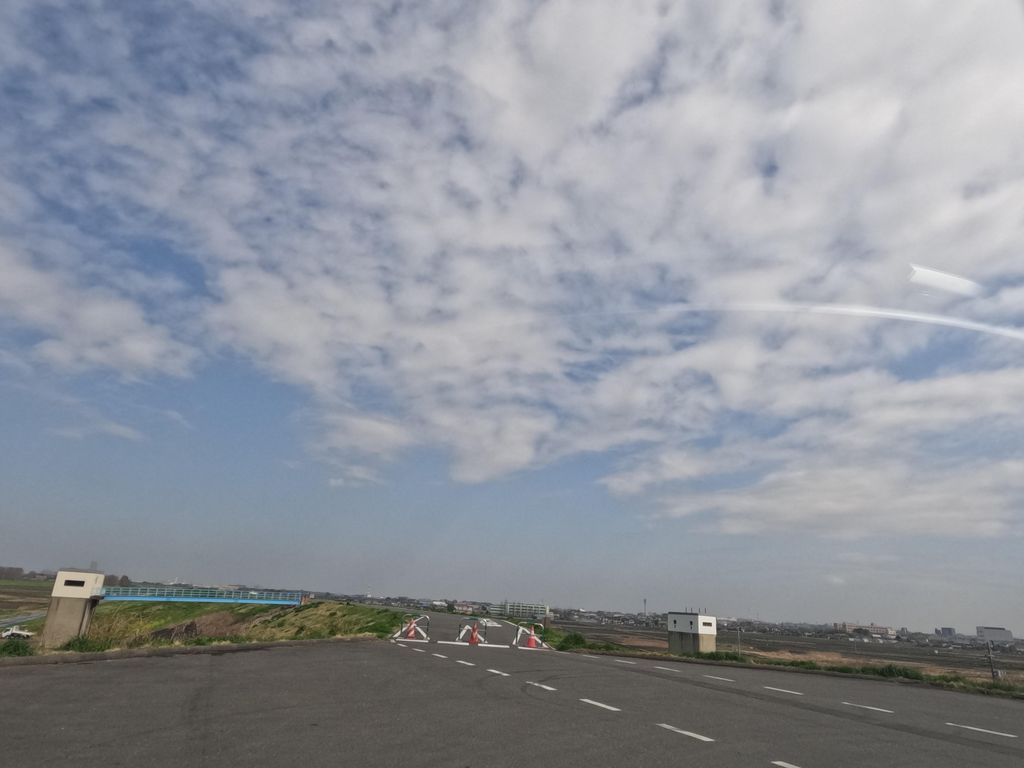
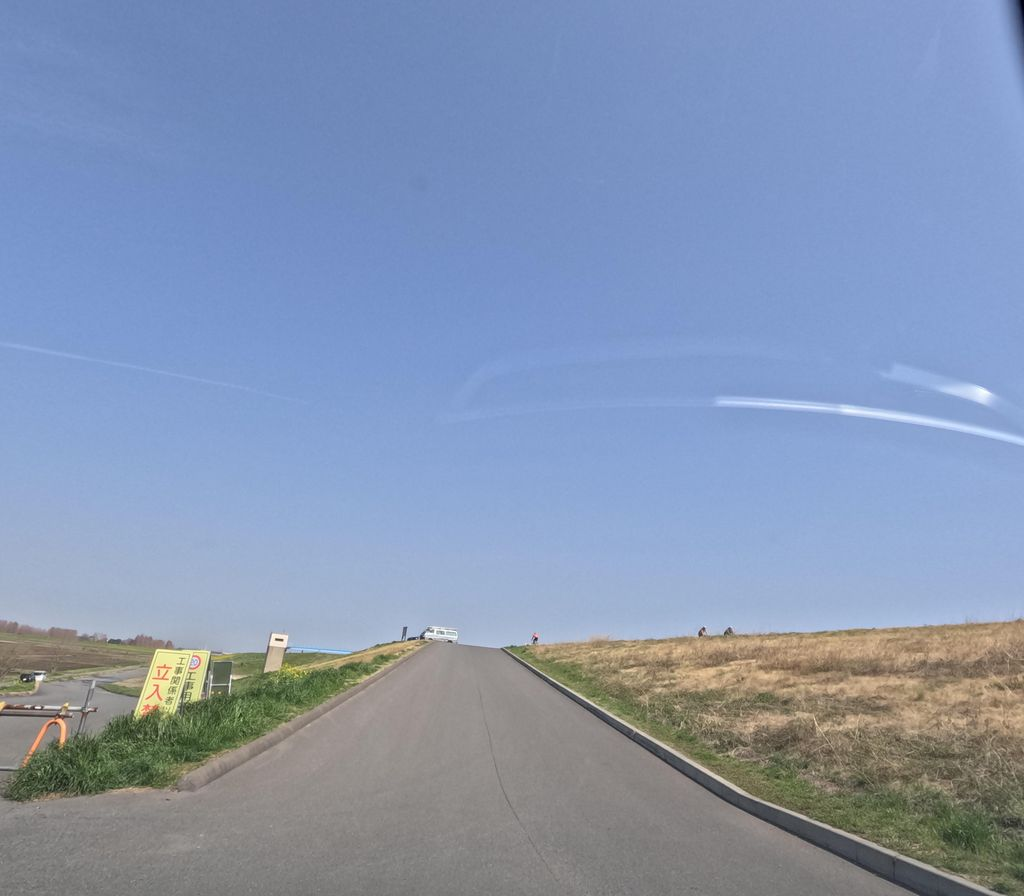
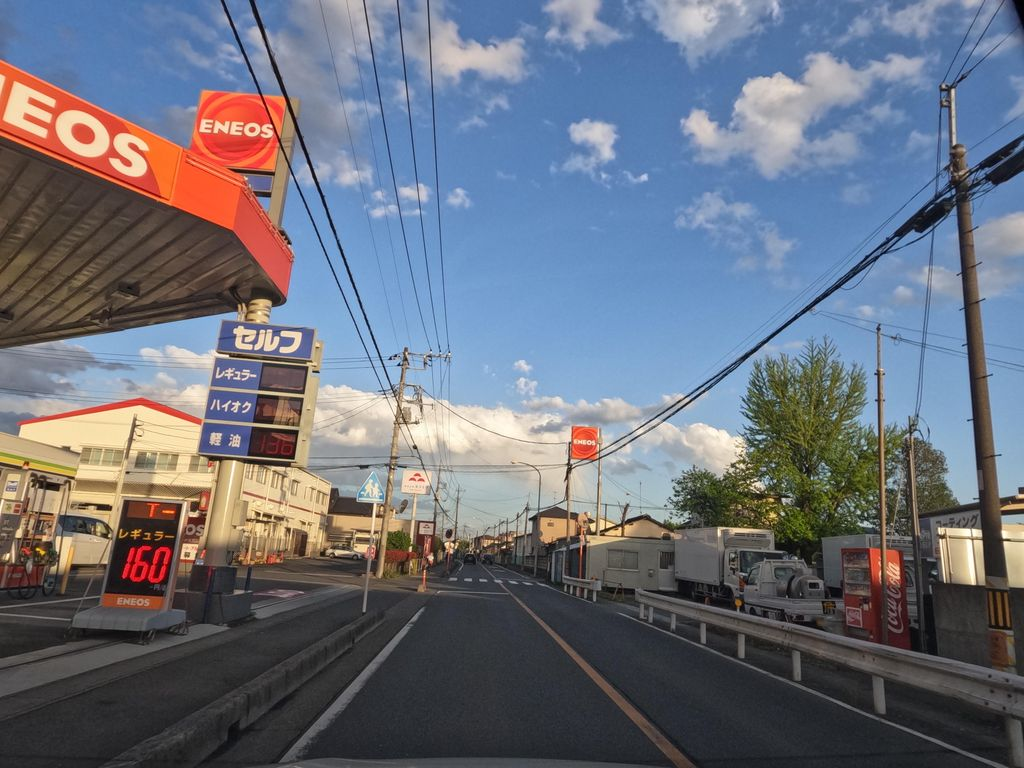
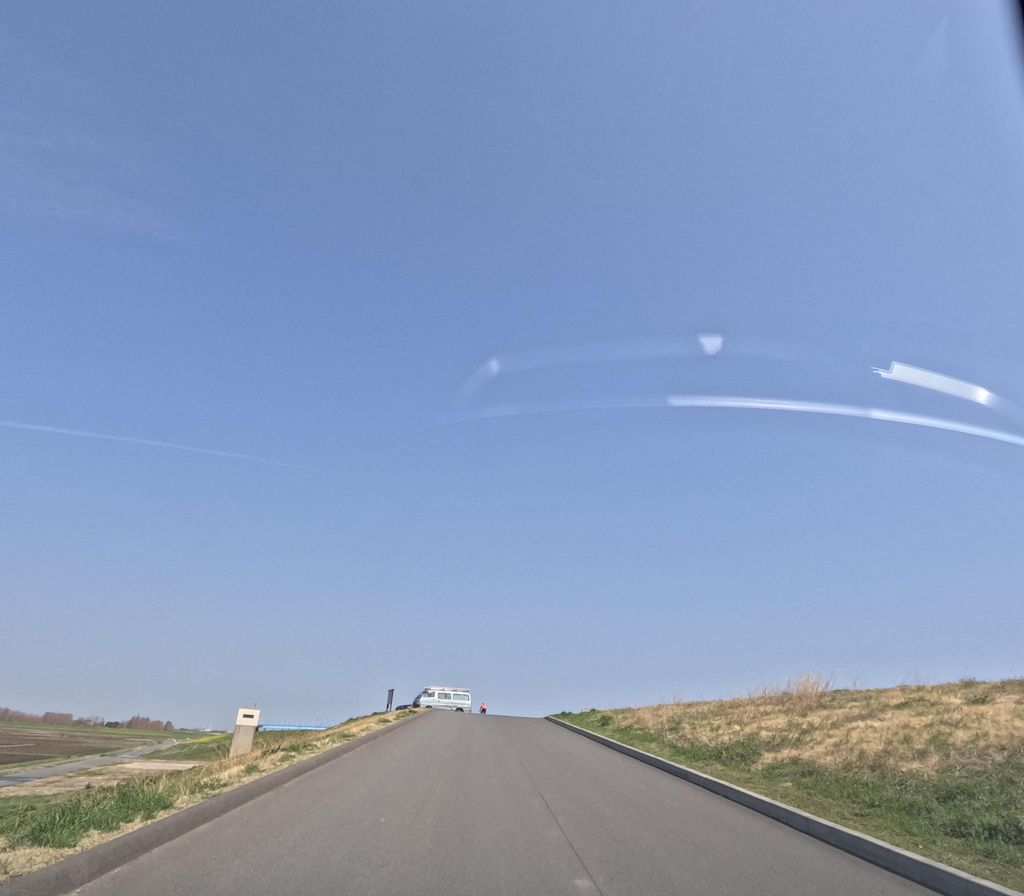
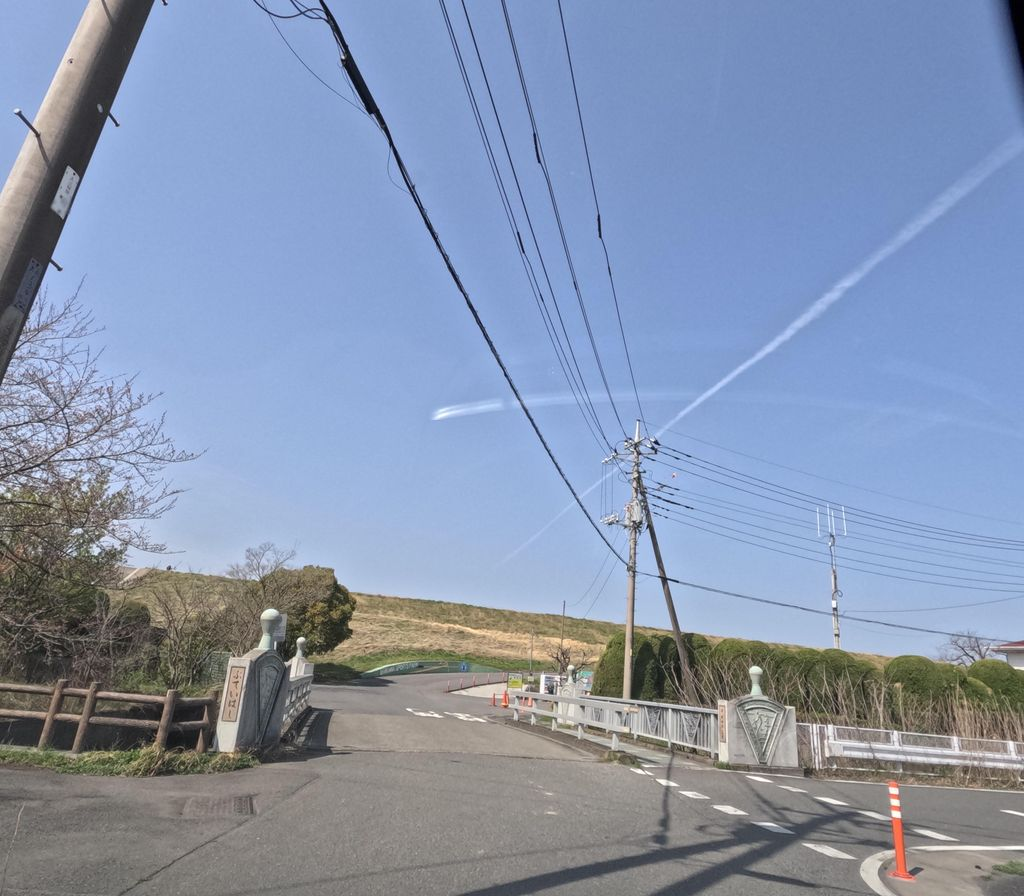
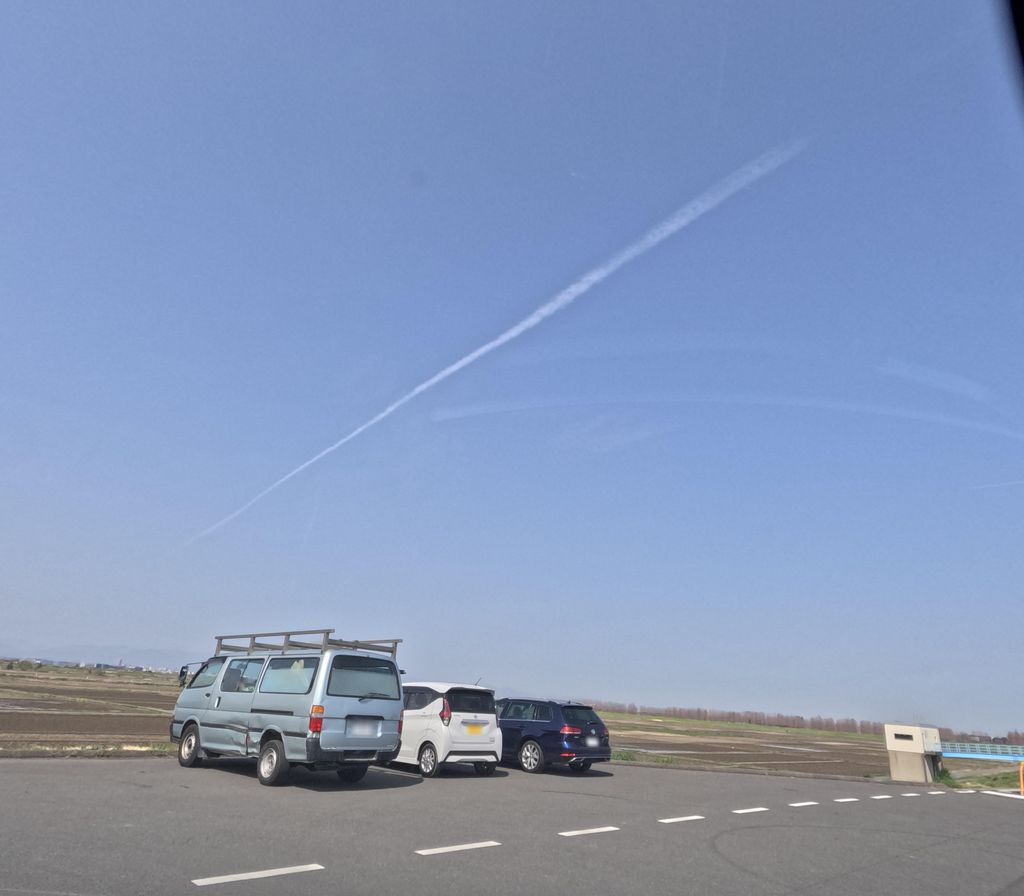
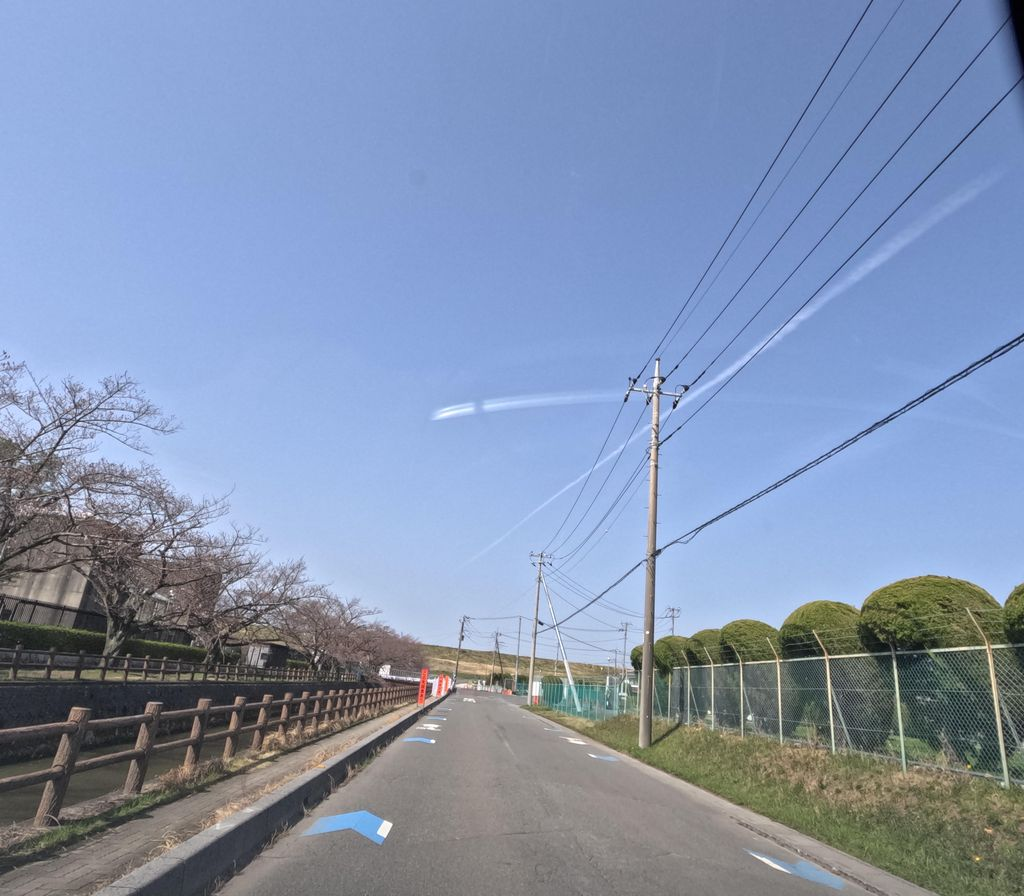
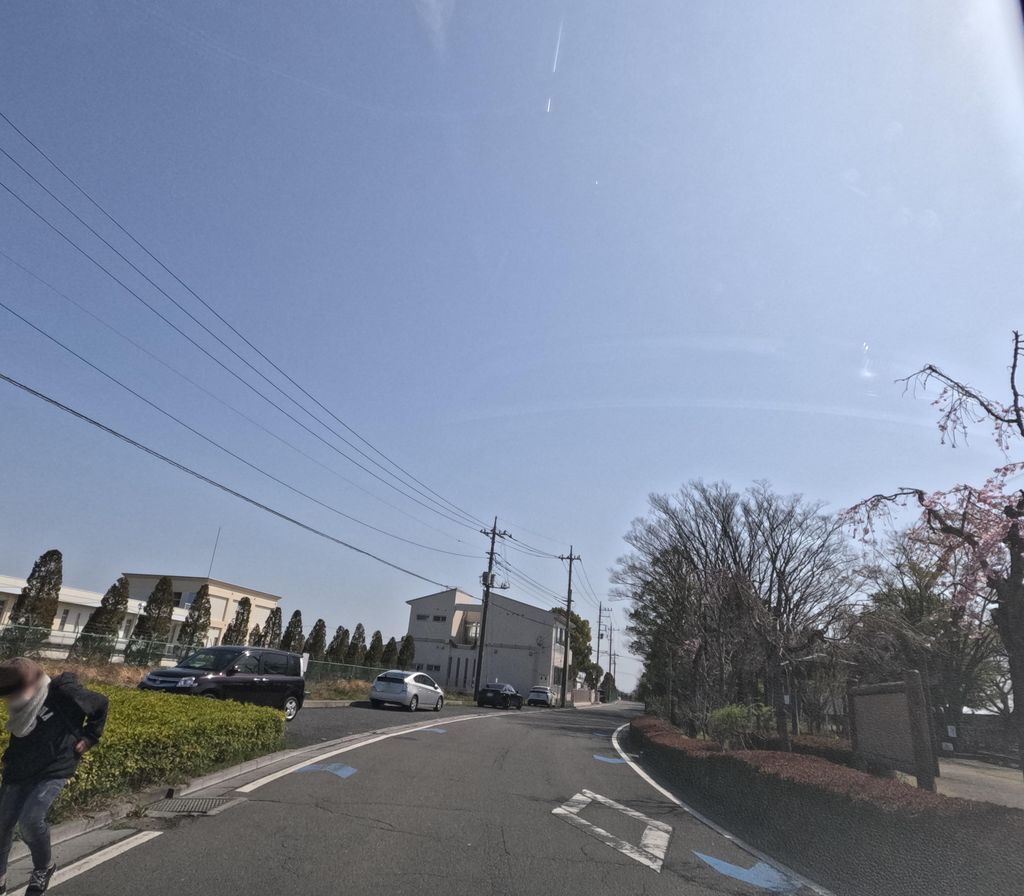
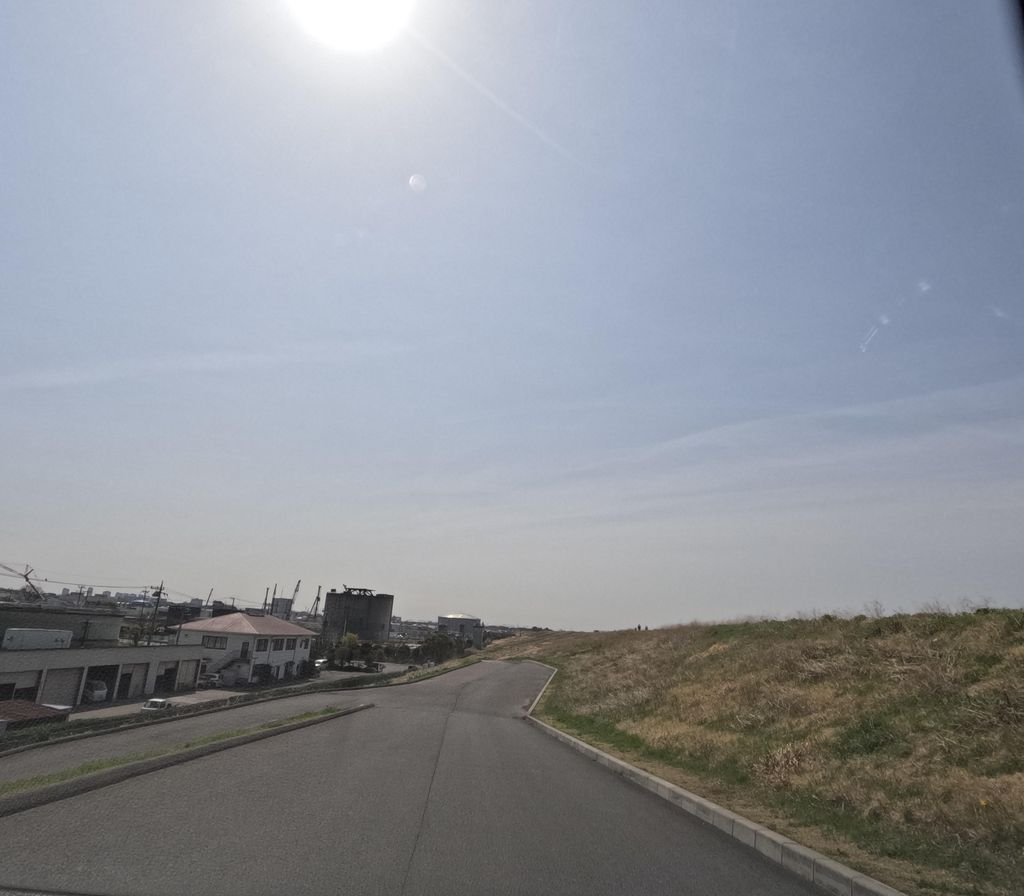
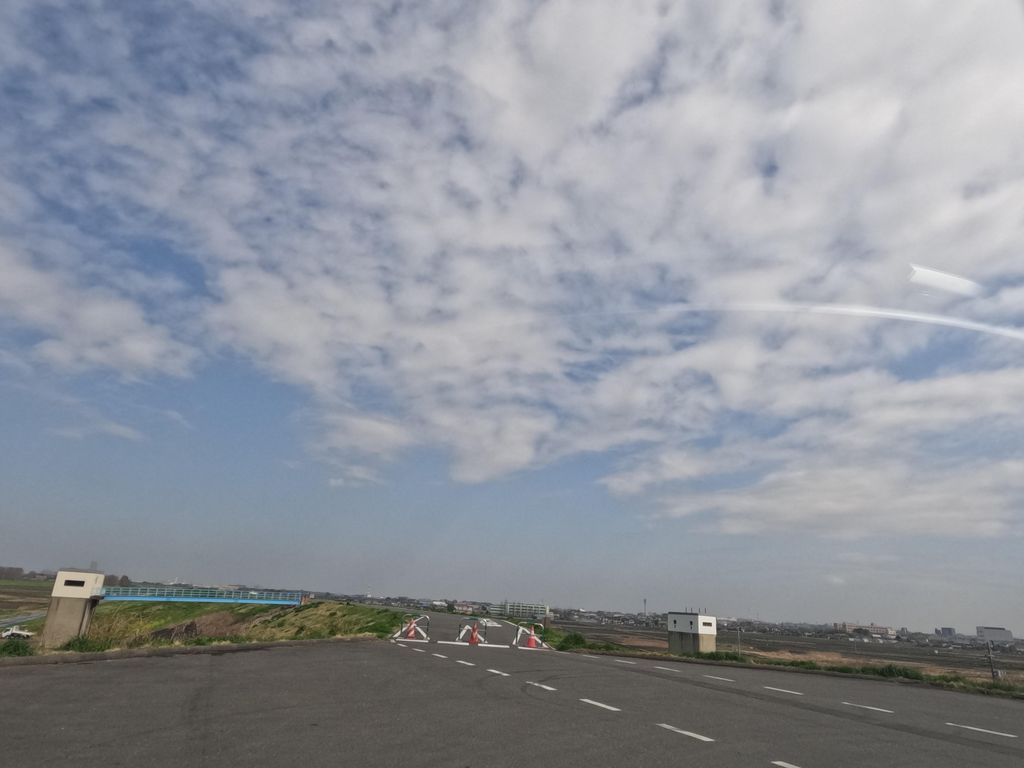
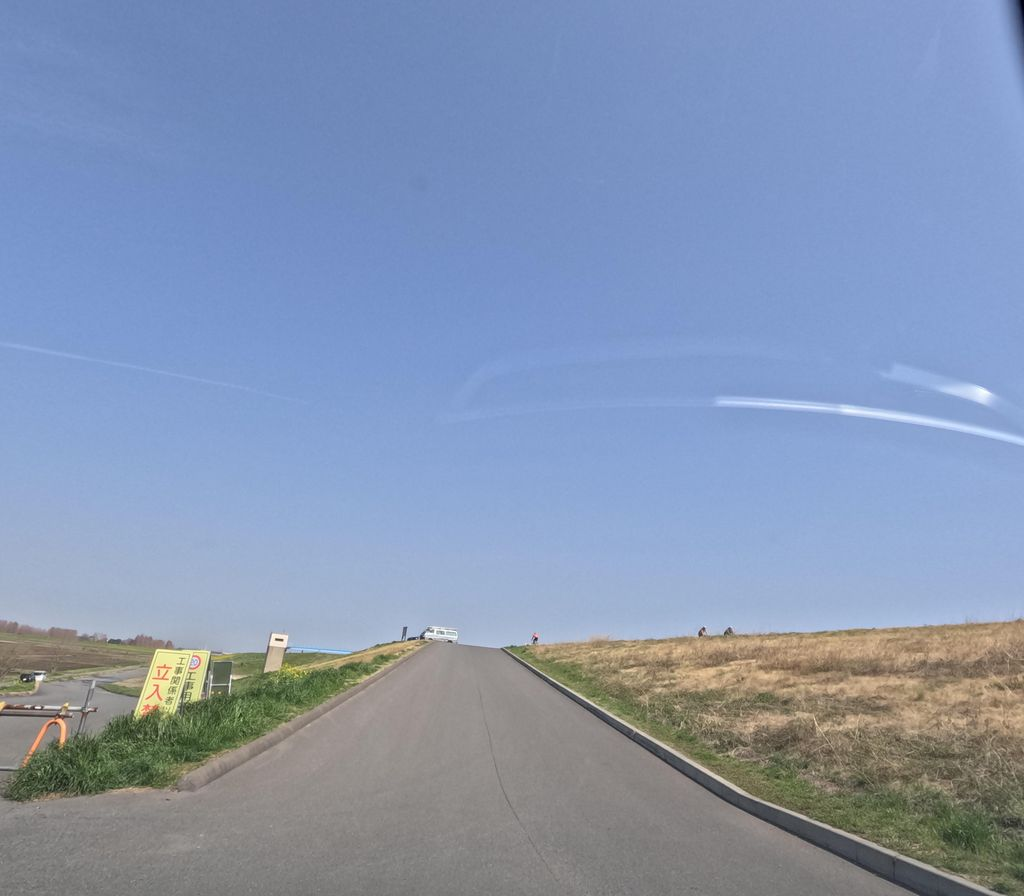
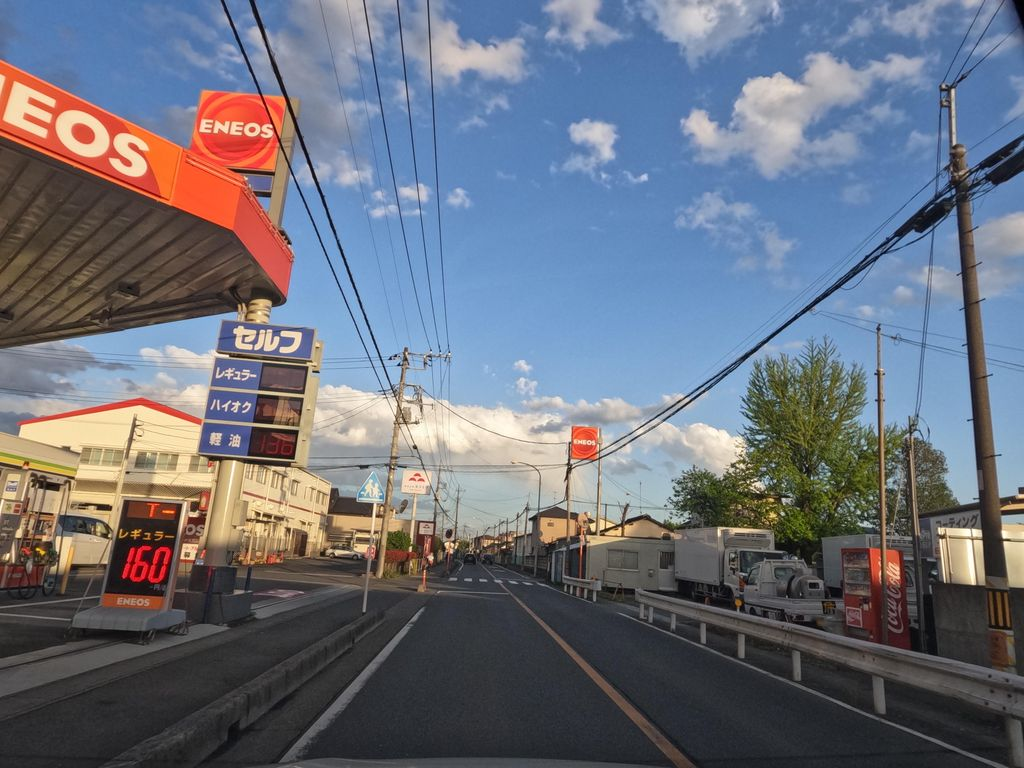
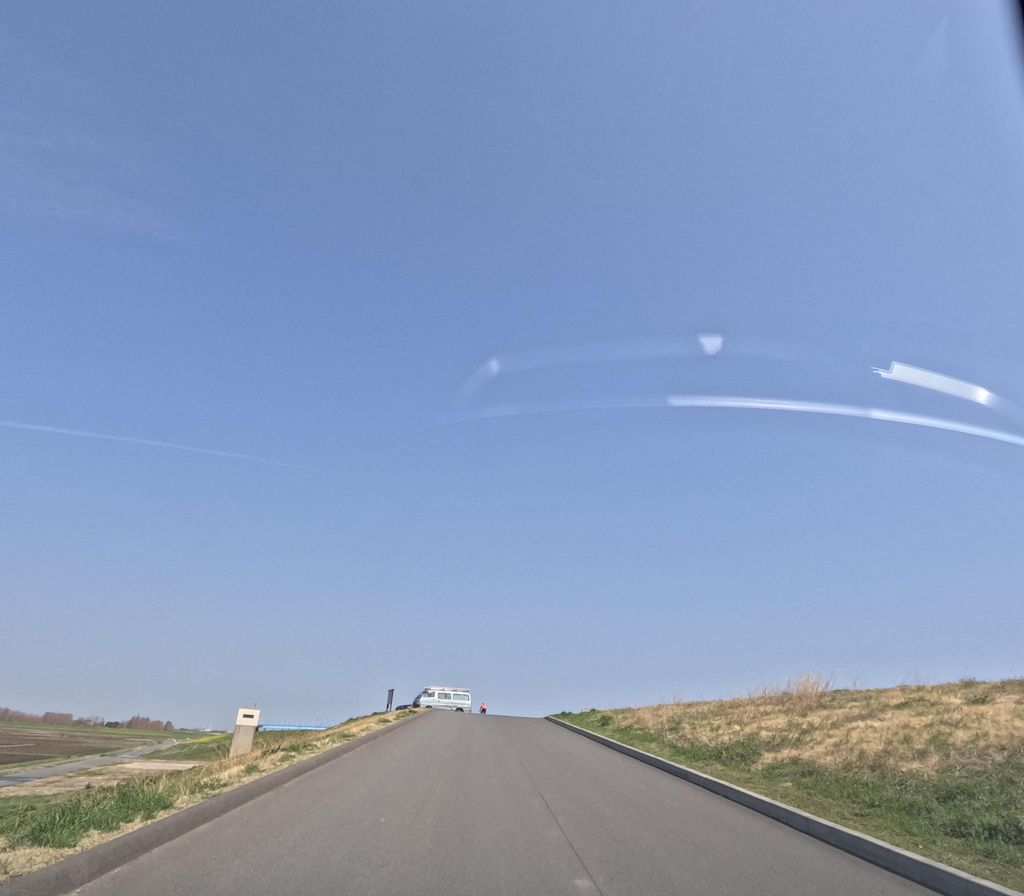
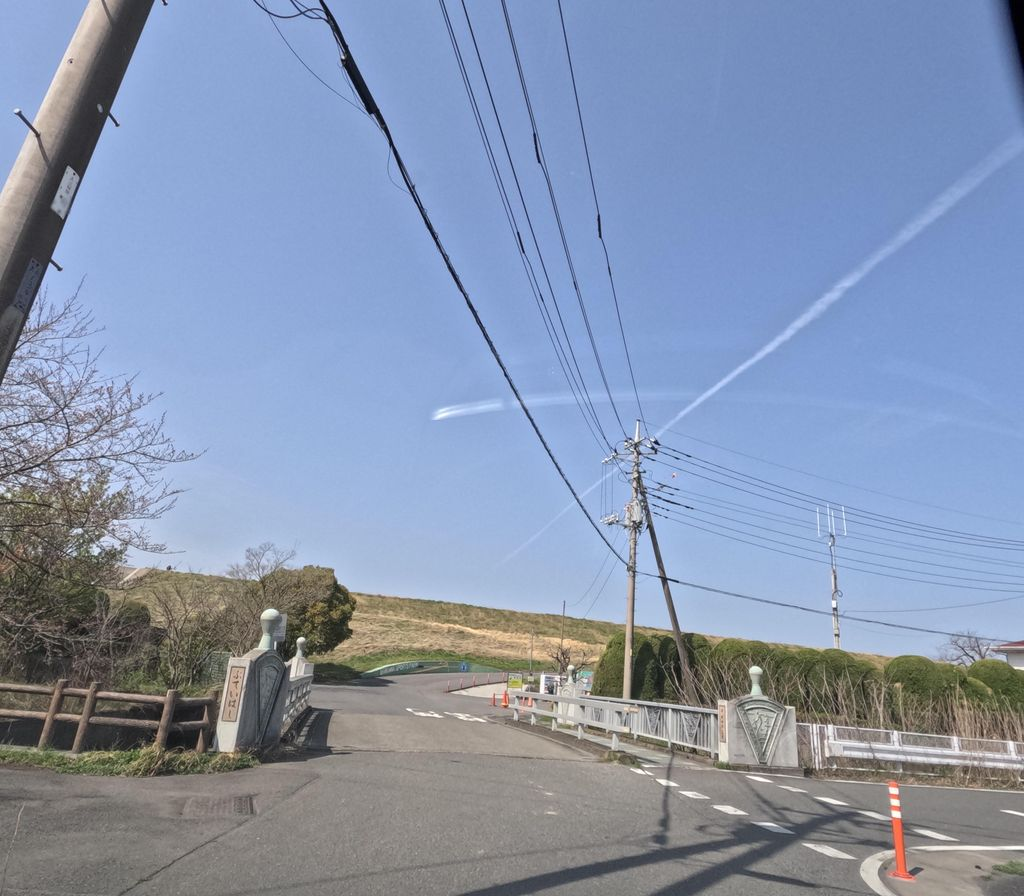
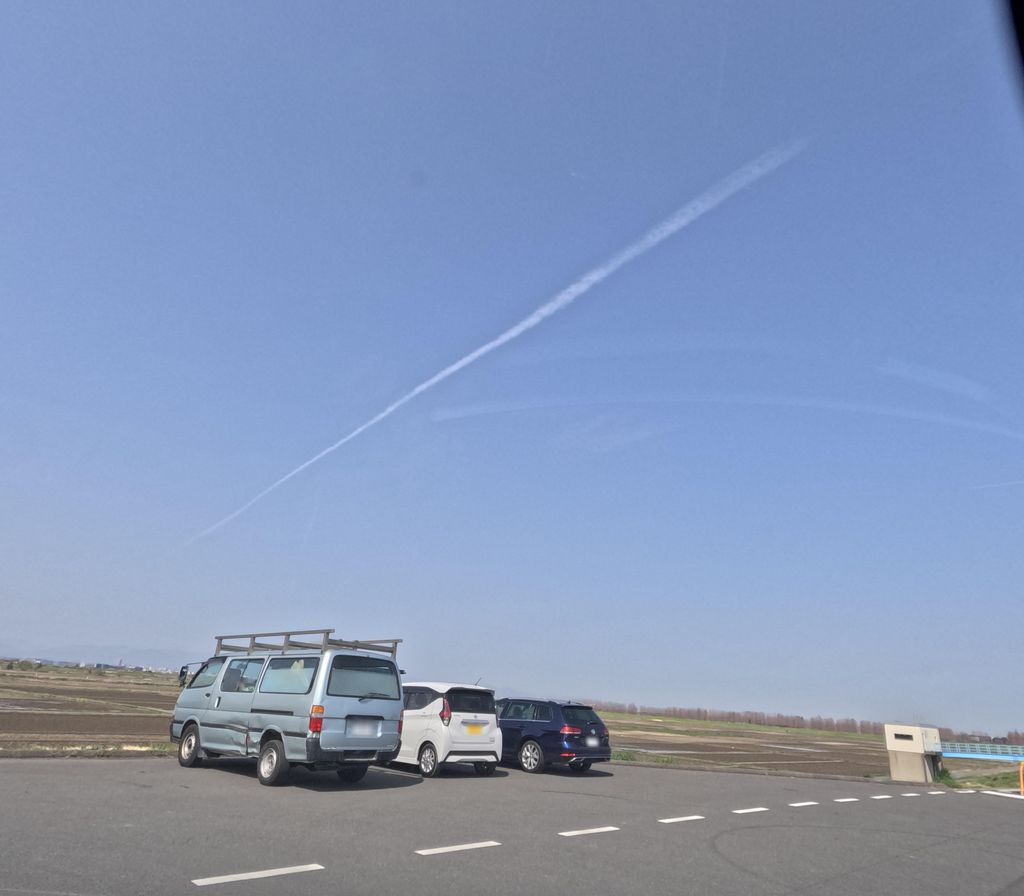
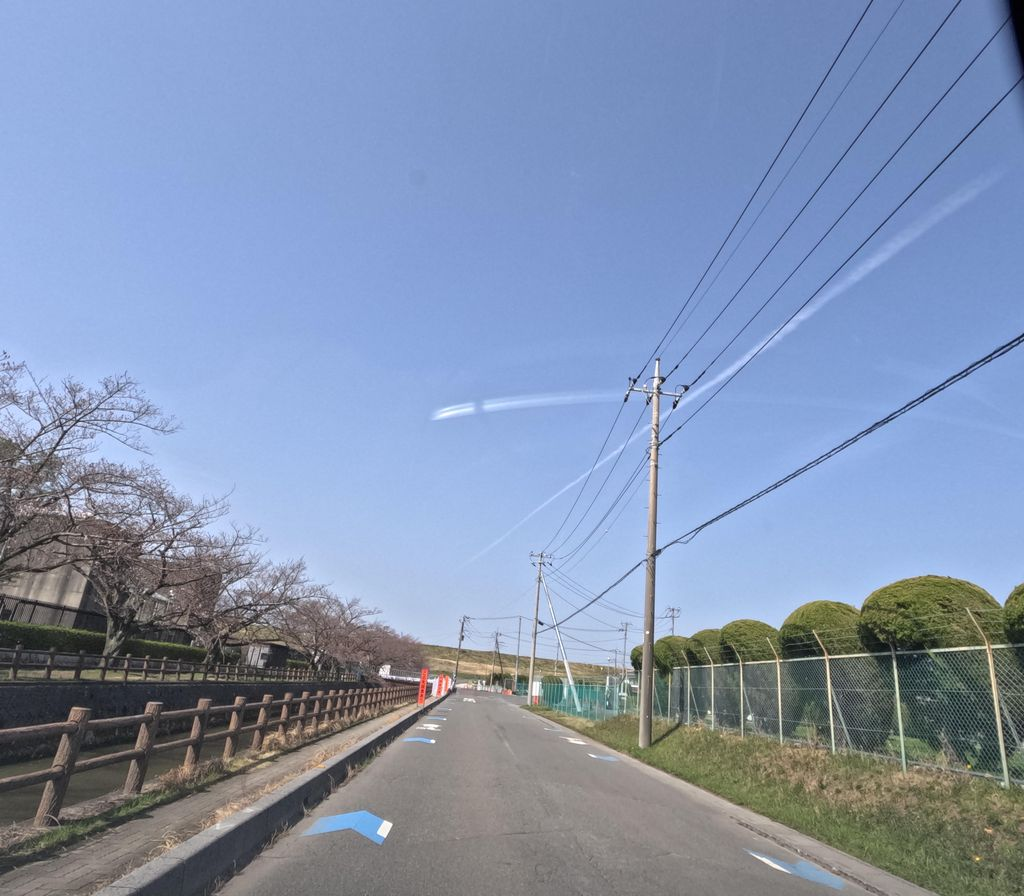
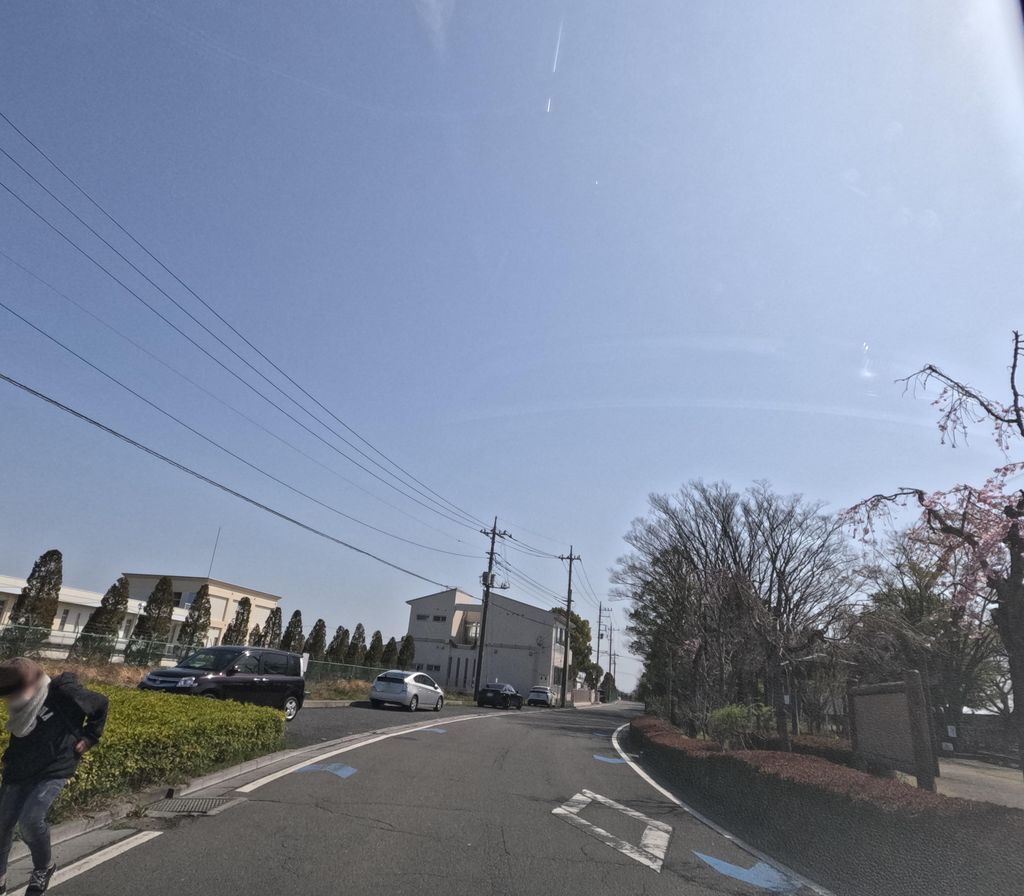
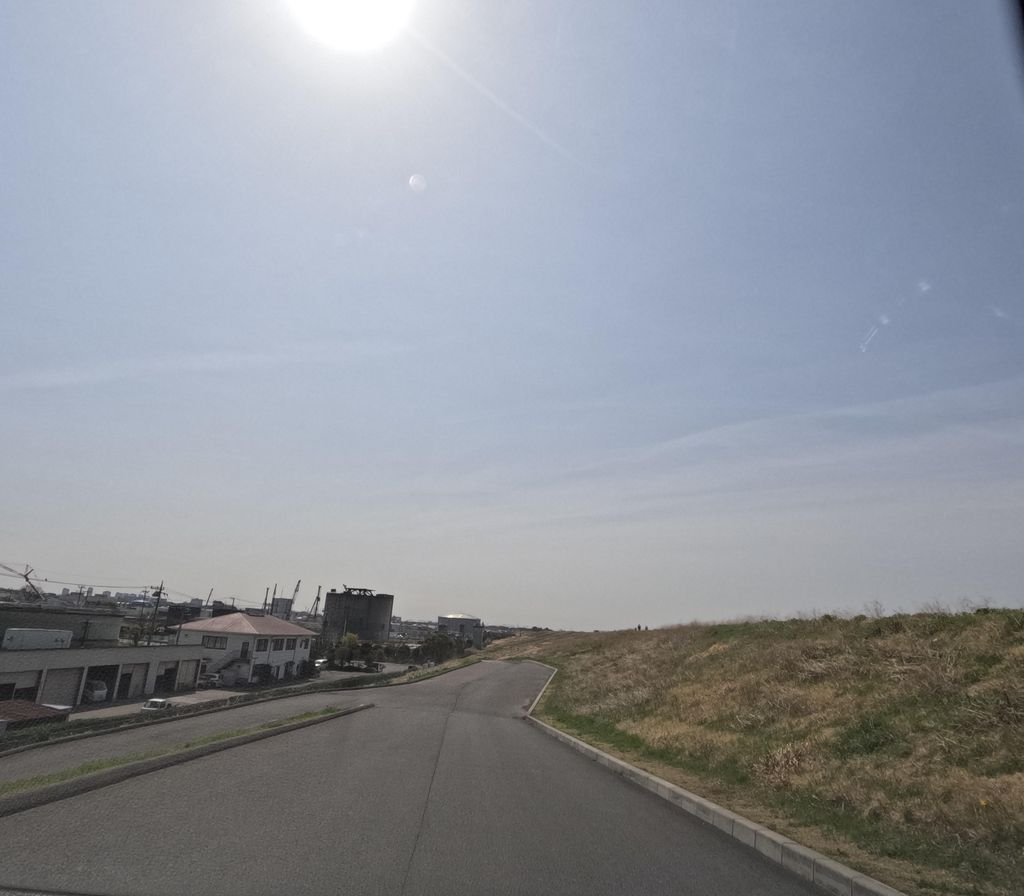

In [17]:
high_alt_map